# Recommender Systems - Task 2 - Full Data

We will a larger filtered dataset in this playbook in terms of movies and users in order to discuss results and algorithm performance.

## Recommender Systems

We use the well-known MovieLens dataset (in this case the small version). You may find the following useful to obtain the data from the GroupLens repository, and to read it into a dataframe.

In [2]:
import os, requests
import numpy as np

mlSize = "ml-1m"
zipUrl = 'http://files.grouplens.org/datasets/movielens/'+mlSize+'.zip'
zipFile = 'data/'+mlSize+'.zip'
dataFile = zipFile
url = zipUrl
dataDir = 'data'
if not os.path.exists(dataDir):
    os.makedirs(dataDir)
if not os.path.isfile(zipFile):
  r = requests.get(zipUrl)
  with open(zipFile, 'wb') as f:
    f.write(r.content)

# Need to unzip the file to read its contents
import zipfile
with zipfile.ZipFile(zipFile,"r") as zip_ref:
  zip_ref.extractall(dataDir)


## TASK 2.1
__Task 2.1__: Read the `users.dat`, `movies.dat` and `ratings.dat` data files into data frames.

In [3]:
import pandas

users = pandas.read_csv('data/ml-1m/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')

ratings = pandas.read_csv('data/ml-1m/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])

movies = pandas.read_csv('data/ml-1m/movies.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre']).set_index('movieid')

In [4]:
users.head()

,gender,age,occupation,zip
userid,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


In [5]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movies.head()

,title,genre
movieid,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [7]:
# We get the number of movies and users:
n_movies = movies.shape[0]
n_users = users.shape[0]

In [8]:
n_movies, n_users

(3883, 6040)

## TASK 2.2
__Task 2.2__: Generate the distribution of ratings (number of user-movie ratings, per rating value).

In order to merge all of the desired information in a single dataframe, we can merge the two dataframes objects on the movieid column since it is common between the two dataframes. This will aid with overall interpretation.

In [9]:
movie_data = pandas.merge(ratings, movies, on='movieid')  
movie_data = pandas.merge(movie_data, users, on='userid')  

In [10]:
movie_data.head()  

,userid,movieid,rating,timestamp,title,genre,gender,age,occupation,zip
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


#### Filtering the datasets and creating the user_movie_rating distribution

I first generate the movie filter aggregate.

In [11]:
minMovieRatings = 100

filterMovies = movie_data['movieid'].value_counts() > minMovieRatings
filterMovies = filterMovies[filterMovies].index.tolist()
len(filterMovies)

2006

I next generate the user filter aggregate.

In [12]:
minUserRatings = 100

filterUsers = movie_data['userid'].value_counts() > minUserRatings
filterUsers = filterUsers[filterUsers].index.tolist()
len(filterUsers)

2909

I create the new dataframe distribution using the isin() filtering function. This allows me to apply both user and movie filters to my movie_data df and create user_movie_rating df.

In [13]:
movie_rating = movie_data["movieid"].isin(filterMovies) 
user_rating = movie_data["userid"].isin(filterUsers) 
user_movie_rating = movie_data[movie_rating & user_rating] 
user_movie_rating.head()

,userid,movieid,rating,timestamp,title,genre,gender,age,occupation,zip
53,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama,M,56,16,70072
54,2,3105,4,978298673,Awakenings (1990),Drama,M,56,16,70072
55,2,2321,3,978299666,Pleasantville (1998),Comedy,M,56,16,70072
56,2,1962,5,978298813,Driving Miss Daisy (1989),Drama,M,56,16,70072
57,2,1207,4,978298478,To Kill a Mockingbird (1962),Drama,M,56,16,70072


## TASK 2.3

__Task 2.3__: Using the filtered ratings dataframe, count the ratings per User and plot this data in a histogram. You should do the same with the Movies and comment on the similarities and differences between the two distributions.

In [14]:
ratings_user_count = pandas.DataFrame(user_movie_rating.groupby('userid')['rating'].count())
ratings_user_count.head()

,rating
userid,
2,125
5,174
8,133
9,104
10,388


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f28bba8>]],
      dtype=object)

<Figure size 576x432 with 0 Axes>

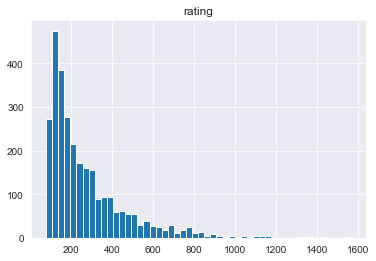

In [15]:
import matplotlib.pyplot as plt  
import seaborn as sns  
sns.set_style('dark')  
%matplotlib inline

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_user_count.hist(bins=50)  

##### Result:
From the histogram and dataframe resultsets we can see that the largest rating peak for users was over 450 ratings.

In [16]:
ratings_movie_count = pandas.DataFrame(user_movie_rating.groupby('movieid')['rating'].count())
ratings_movie_count.head()

,rating
movieid,
1,1566
2,624
3,394
4,160
5,268


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128be4c18>]],
      dtype=object)

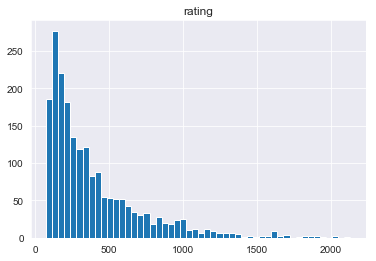

In [17]:
ratings_movie_count.hist(bins=50) 

##### Result:
From the histogram and dataframe resultsets we can see that for the movie / rating grouping, there are far more films with roughly 270 ratings on the film. This rating count, it should noted, is not the rating value of the movie, rather the count of times it was rated.

##### Similarities and Differences

From comparing the histograms for rating counts by userid and by movieid, the following comments can be made:
* Educated guesses can only be made from comparing the histograms as to which user provided which ratings, unless we dive deeper into the data.
* The majority of the movies have received more than 270 ratings, There looks to have been one film which was rated over 2000 times.

## TASK 2.4

__Task 2.4__: Repeat Task 2.3 above, but deriving the average ratings rather than their counts.

In [18]:
ratings_user_average = pandas.DataFrame(user_movie_rating.groupby('userid')['rating'].mean())
ratings_user_average.head()

,rating
userid,
2,3.720000
5,3.166667
8,3.902256
9,3.750000
10,4.113402


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128b23080>]],
      dtype=object)

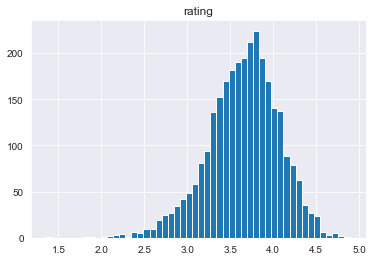

In [19]:
ratings_user_average.hist(bins=50) 

##### Result:
From the histogram and dataframe resultsets we can see that for the users in the filtered dataset, we have the highest average rating of roughly 3.7.

In [20]:
ratings_movie_average = pandas.DataFrame(user_movie_rating.groupby('movieid')['rating'].mean())
ratings_movie_average.head()

,rating
movieid,
1,4.146232
2,3.171474
3,2.969543
4,2.731250
5,3.003731


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110895fd0>]],
      dtype=object)

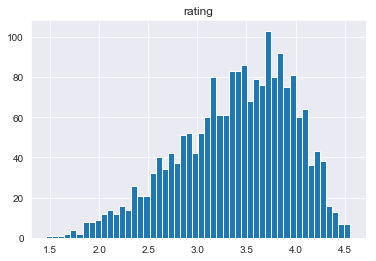

In [21]:
ratings_movie_average.hist(bins=50) 

##### Result:
From the histogram and dataframe resultsets we can see that for the movie / rating grouping, the highest raint avergave was again just over 3.7

##### Similarities and Differences
From comparing the histograms for average ratings by userid and by movieid, the following comments can be made:

* The averages between the users versus movies ratings datasets was very similar in terms of the hightest trending rating of roughly 3.7.
* We look to have a siginificantly larger disctribution of movies to ratints ratio than we do users to ratings from looking at the histogram width.

## TASK 2.5

__Task 2.5__: Load the (filtered) movies ratings data from the dataframe we have been exploring into the preferred 3-column format used by the `scikit-suprise` package. Now benchmark the performance (in terms of RMS error, time to fit, and time to generate predictions for test data) of the `SVD()`, `SlopeOne()`, `NMF()`, `KNNBasic()` recommendation algorithms. Discuss the strengths and weaknesses of each algorithm, based on its benchmarked results.

In [24]:
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset
from surprise import SVD, SlopeOne, NMF, KNNBasic

reader = Reader()
data = Dataset.load_from_df(user_movie_rating[['userid', 'movieid', 'rating']], reader)

Next we loop over the algorithms and get the resulting benchmarks for each.
5-fold cross-validation was used to estimate the errors and their standard deviations was used on each algorithm.

In [25]:
for algo in [SVD(), SlopeOne(), NMF(), KNNBasic()]:
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8551  0.8556  0.8552  0.8578  0.8565  0.8560  0.0010  
MAE (testset)     0.6712  0.6716  0.6710  0.6731  0.6715  0.6717  0.0007  
Fit time          37.34   36.36   36.15   35.25   35.33   36.08   0.77    
Test time         1.27    2.04    1.52    1.49    1.68    1.60    0.26    
Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8942  0.8956  0.8950  0.8933  0.8952  0.8947  0.0008  
MAE (testset)     0.7051  0.7061  0.7055  0.7044  0.7067  0.7056  0.0008  
Fit time          11.99   12.36   12.17   12.41   12.25   12.24   0.15    
Test time         46.47   45.90   46.58   46.44   46.07   46.29   0.26    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (te

### SVD Results

#### Strengths
* Useful for achieving a minimal RMSE(Root Mean Square Error) result.
* Acts as a means of Dimensionality reduction similar in comparison to PCA which maps nicely with a collaborative filtering dataset such as the movie dataset.
* While the mean RMSE was 0.8560 and MAE was 0.6717, in comparison to the other algorithm results, this was the best performing of the four.
* MAE was much improved here and could be considered a good result.
* Test time was quite the lowest at 1.60 mean.

#### Weaknesses
* The main drawback of SVD is that there is little to no explanation to the reason that we recommend an item to an user. This can be a huge problem if users are eager to know why a specific item is recommended to them.
* Requires care when used with missing data. Gradient Approach is better suited to missing data handling.
* Mean RMSE was 0.8560 which is quite high and not considered a successsful result for prediction errors. 
* Fit time was the highest at 36.08 mean.

### SlopeOne Results

#### Strengths
* SlopeOne is a straightforward implementation of the SlopeOne algorithm.
* While the mean RMSE was 0.8947 and MAE was 0.7056, in comparison to the other algorithm results, this was the second best performing of the four, next after SVD.
* Fit time was the lowest at 12.24 mean.
* While it still requires a huge amount of preprocessing to compute values comparing each item in the dataset with each other item, it is generally faster than other approaches, as it uses half the number of predictor regressions. 
* Allows for making certain predictions about user-rating similarity which is very useful.

#### Weaknesses
* Mean RMSE was 0.8947 which is quite high and not considered a successsful result for prediction errors.
* Mean MAE was 0.7056 which again is still high and not considered a successsful result for prediction errors, although we did see a reduction of 19 percent in comparison to RMSE here.
* Has known scalability issues, so larger datasets may not perform as well. This is not as noticeable here, but will be checked on the extended resultset.
* Works well for ratings but not as well for binary data (yes or no).
* Test time was second highest at 46.29 mean.

### NMF Results

#### Strengths
* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar to SVD. 
* Test time was very optimal at 1.72.

#### Weaknesses
* Fit time was second highest at 35.64 mean.
* Mean RMSE was 0.9023 which was the highest in this category and not considered a successsful result for prediction errors.
* Mean MAE was 0.7132 which again was the highest in this category and not considered a successsful result for prediction errors, although we did see a reduction of almost 20 percent in comparison to RMSE here.
* Overall NMF performed the worst of the four algorithms in terms of error rate.
* The NMF algorithm may have problems if the values are not independent. This may cause difficulties in more complex datasets.

### KNNBasic Results

#### Strengths
* Simplistic, basic collaborative filtering algorithm.
* Uses the K-nearest neighbors approach which is easy to understand from working on other data mining categories.
* Fit time was second lowest at 17.66 mean.

#### Weaknesses
* Mean RMSE was 0.8965 which was the second highest in this category and not considered a successsful result for prediction errors.
* Mean MAE was 0.7055 which again was the second highest in this category and not considered a successsful result for prediction errors, although we did see a significant reduction of almost 19 percent in comparison to RMSE here.
* Test time was the highest out of the four at 73.64.

### Overall Algorithm Winner = SVD